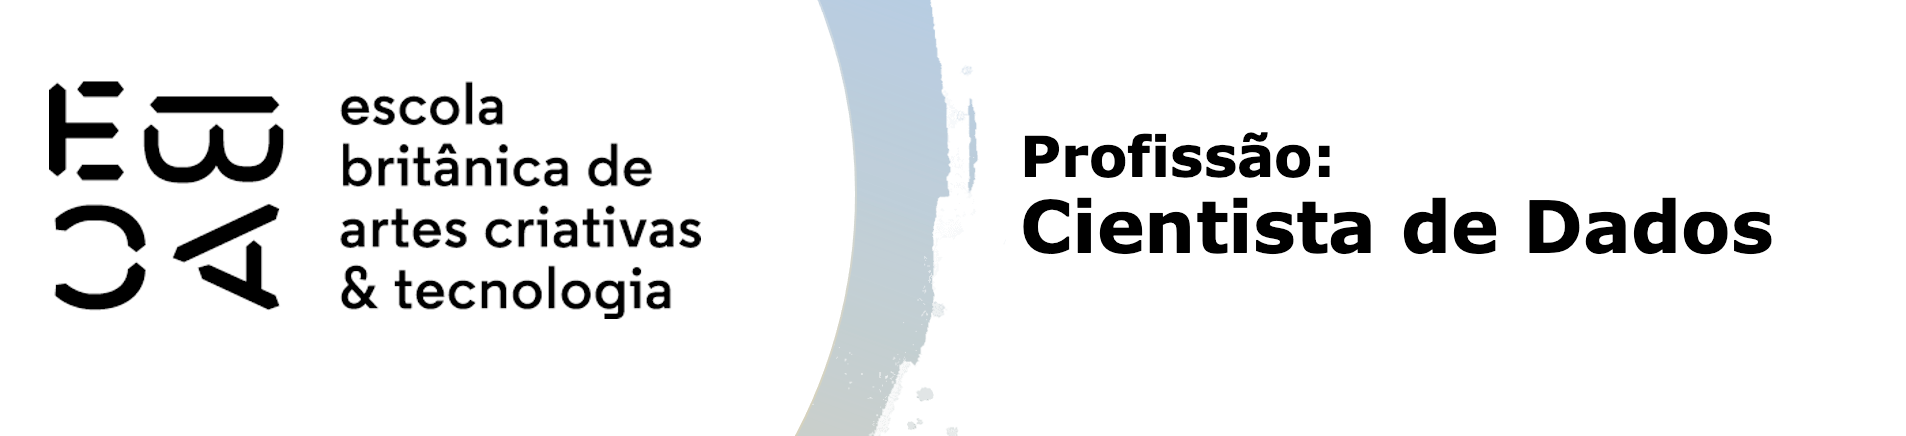

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t

/Users/rayssaathayde/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#importar base de dados
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [3]:
#conferindo se coluna de datas já está no formato correto
df.dtypes

data_ref                 datetime64[ns]
index                             int64
sexo                             object
posse_de_veiculo                 object
posse_de_imovel                  object
qtd_filhos                        int64
tipo_renda                       object
educacao                         object
estado_civil                     object
tipo_residencia                  object
idade                             int64
tempo_emprego                   float64
qt_pessoas_residencia           float64
renda                           float64
mau                                bool
dtype: object

In [4]:
# Transformar a variável resposta em inteiro
df['mau'] = df.mau.astype('int64')
#drop da coluna index
df.drop('index', axis=1, inplace=True)

In [5]:
#verificando a data máxima no df para separar últimos 3 meses
df['data_ref'].max()

Timestamp('2016-03-01 00:00:00')

In [6]:
#separar base teste com últimos 3 meses 
df_teste = df.loc[df['data_ref'] >= '2016-01-01']

print(f''' 
    Data mínima da base teste: {df_teste['data_ref'].min()}.
    Data máxima da base teste: {df_teste['data_ref'].max()}.
    ''') 

 
    Data mínima da base teste: 2016-01-01 00:00:00.
    Data máxima da base teste: 2016-03-01 00:00:00.
    


In [7]:
#separar base treino 
df_treino = df.loc[df['data_ref'] < '2016-01-01']

print(f''' 
    Data mínima da base treino: {df_treino['data_ref'].min()}.
    Data máxima da base treino: {df_treino['data_ref'].max()}.
    ''') 

 
    Data mínima da base treino: 2015-01-01 00:00:00.
    Data máxima da base treino: 2015-12-01 00:00:00.
    


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [8]:
print(f'A base tem {df.shape[0]} linhas.')

A base tem 750000 linhas.


In [9]:
#quantidade de linhas por mês
linhas_mes = df.groupby(df['data_ref'].dt.month).count()
linhas_mes['data_ref']

data_ref
1     100000
2     100000
3     100000
4      50000
5      50000
6      50000
7      50000
8      50000
9      50000
10     50000
11     50000
12     50000
Name: data_ref, dtype: int64

In [10]:
df.dtypes

data_ref                 datetime64[ns]
sexo                             object
posse_de_veiculo                 object
posse_de_imovel                  object
qtd_filhos                        int64
tipo_renda                       object
educacao                         object
estado_civil                     object
tipo_residencia                  object
idade                             int64
tempo_emprego                   float64
qt_pessoas_residencia           float64
renda                           float64
mau                               int64
dtype: object

In [12]:
cols_qtt = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cols_qlt = df.select_dtypes(exclude=['int64', 'float64']).columns.drop('data_ref').tolist()

print(f'''
As colunas quantitativas da base são: {cols_qtt}.
As colunas qualitativas da base são: {cols_qlt}.''')


As colunas quantitativas da base são: ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda', 'mau'].
As colunas qualitativas da base são: ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'].


/var/folders/wh/n65332rj7vx8p0vjpl2bjx8h0000gn/T/ipykernel_19530/601512947.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/wh/n65332rj7vx8p0vjpl2bjx8h0000gn/T/ipykernel_19530/601512947.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/wh/n65332rj7vx8p0vjpl2bjx8h0000gn/T/ipykernel_19530/601512947.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/wh/n65332rj7vx8p0vjpl2bjx8h0000gn/T/ipykernel_19530/601512947.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/wh/n65332rj7vx8p0vjpl2bjx8h0000gn/T/ipykernel_19530/601512947.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/wh/n65332rj7vx8p0vjpl2bjx8h0000gn/T/ipykernel_19530/601512947.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


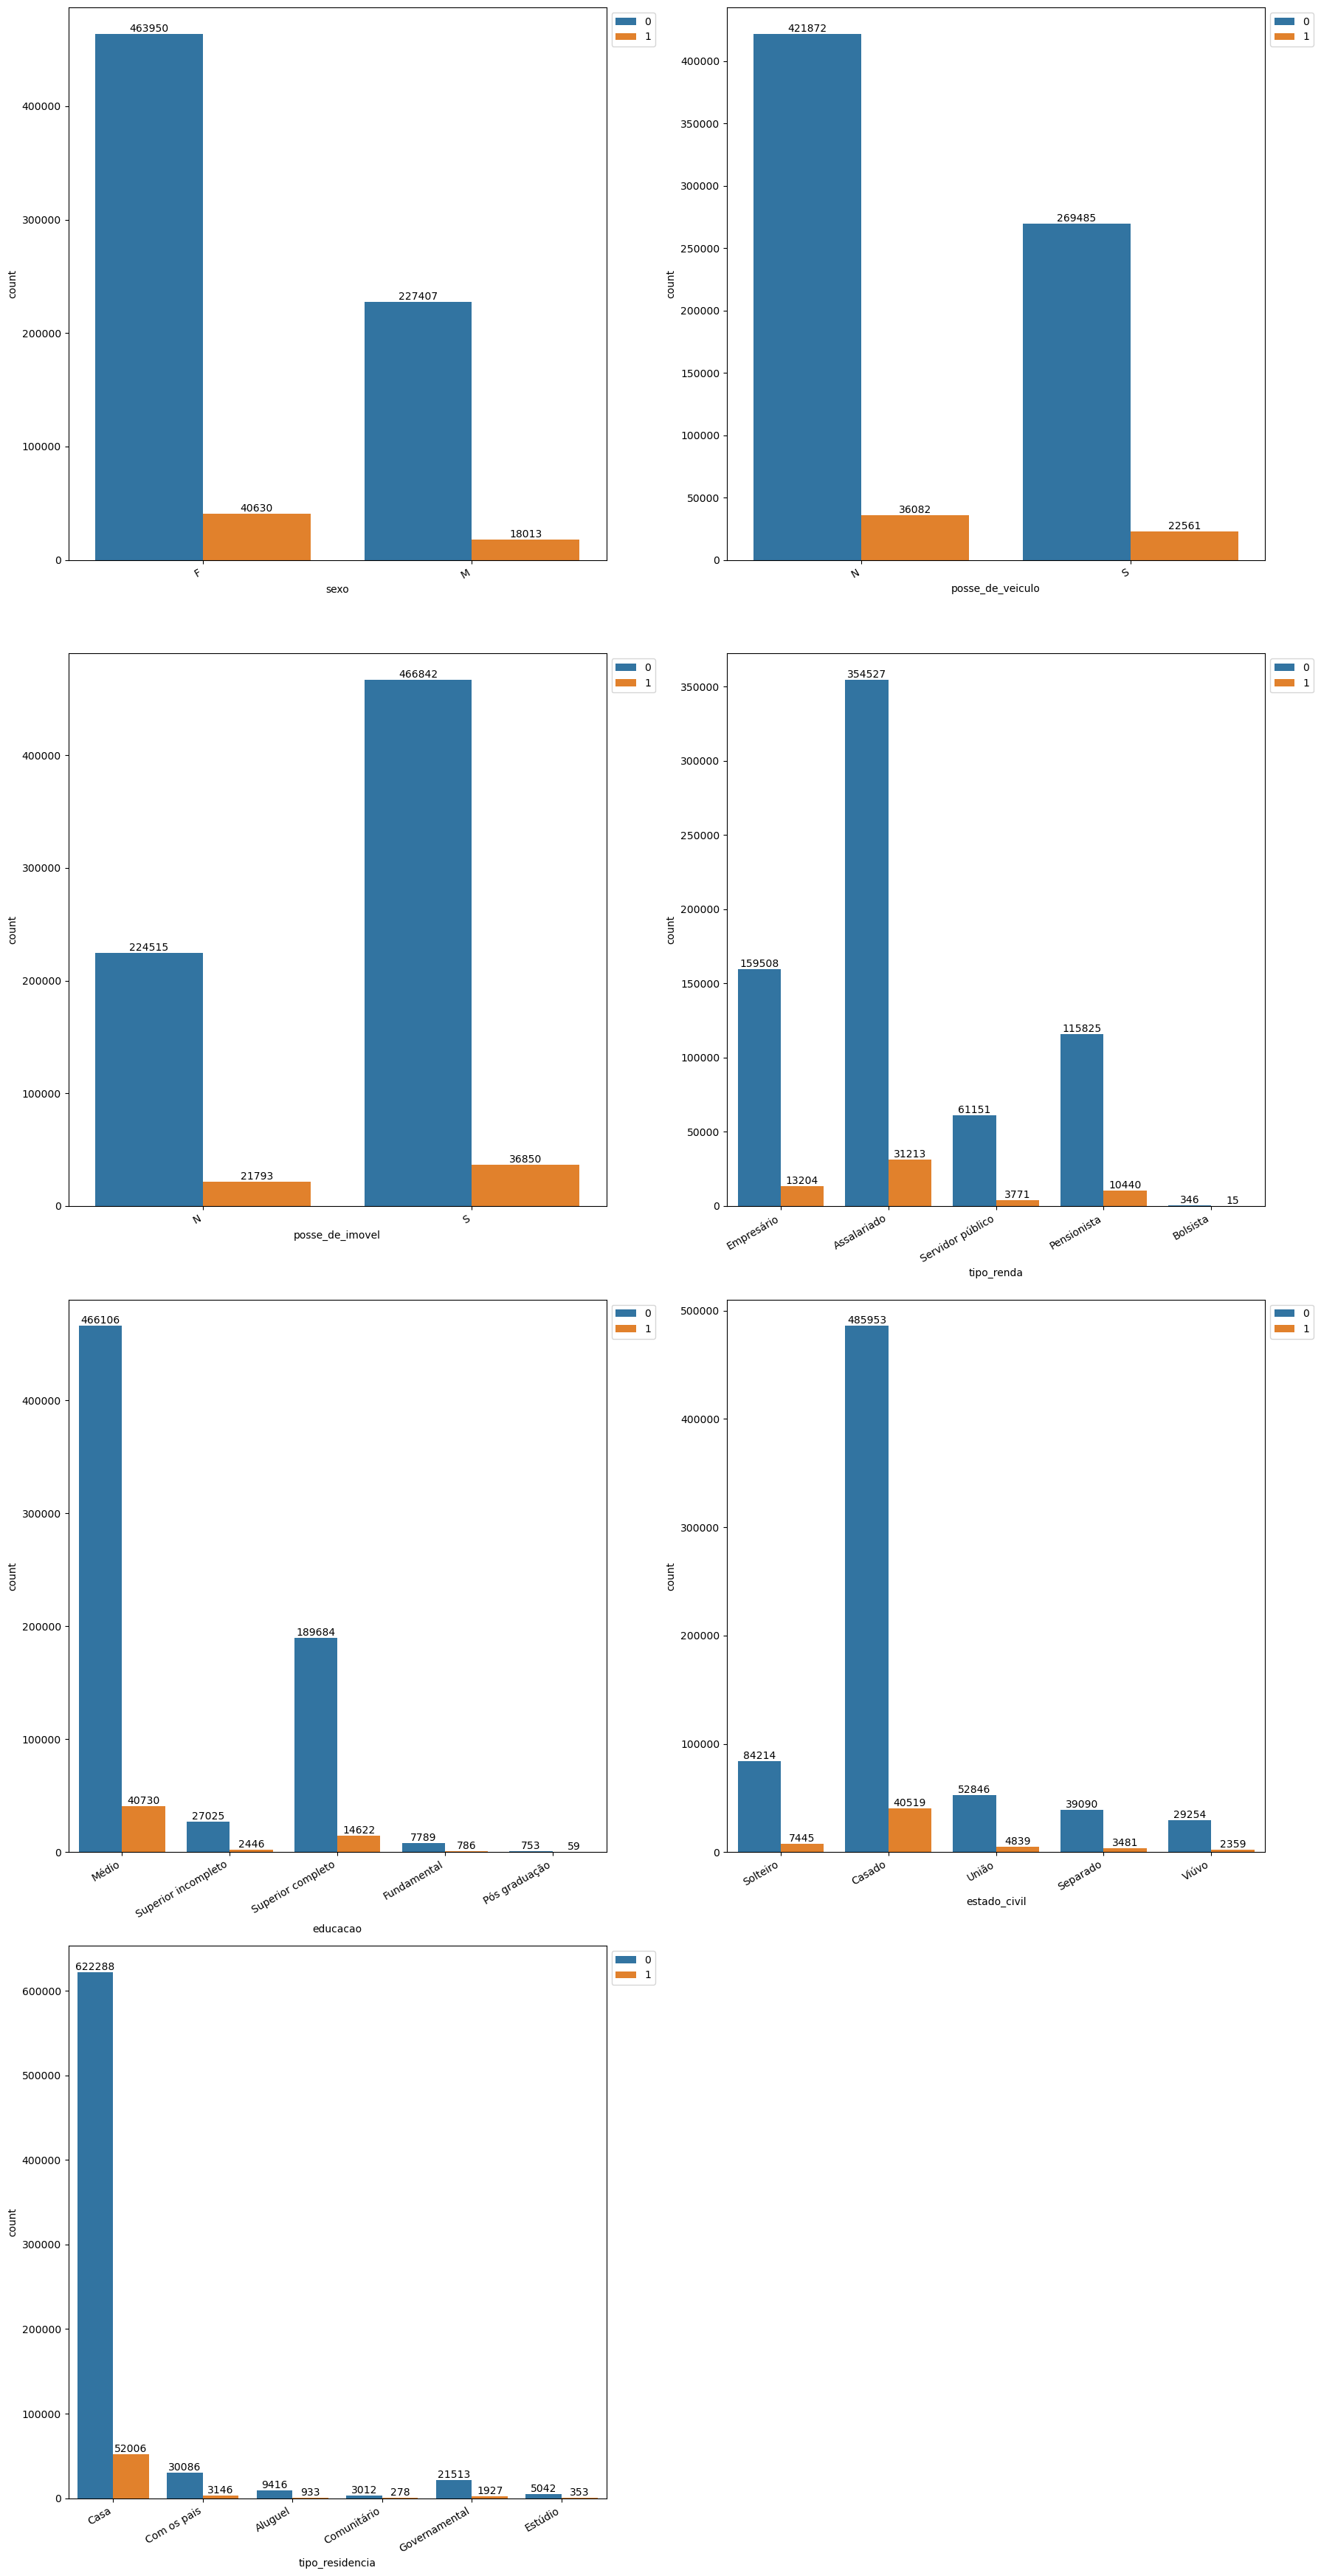

In [13]:
plt.figure(figsize=(18,35))

for i, col in enumerate(cols_qlt):
    ax=plt.subplot(4,2 , i+1)
    sns.countplot(data=df, x=col, hue='mau')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
    for label in ax.containers:
        ax.bar_label(label)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()  
    

In [14]:
df.drop(columns=['data_ref']).describe()

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
count,750000.000000,750000.000000,624043.000000,750000.000000,7.500000e+05,750000.000000
mean,0.433251,43.804733,7.748574,2.212241,2.323854e+04,0.078191
std,0.739379,11.229868,6.687455,0.903428,7.910601e+04,0.268472
min,0.000000,22.000000,0.117808,1.000000,1.076700e+02,0.000000
25%,0.000000,34.000000,3.049315,2.000000,3.467700e+03,0.000000
50%,0.000000,43.000000,6.046575,2.000000,7.861820e+03,0.000000
75%,1.000000,53.000000,10.183562,3.000000,1.831828e+04,0.000000
max,14.000000,68.000000,42.906849,15.000000,4.083986e+06,1.000000


/Users/rayssaathayde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rayssaathayde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/rayssaathayde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/rayssaathayde/anaconda3/lib/python3.11/site-packag

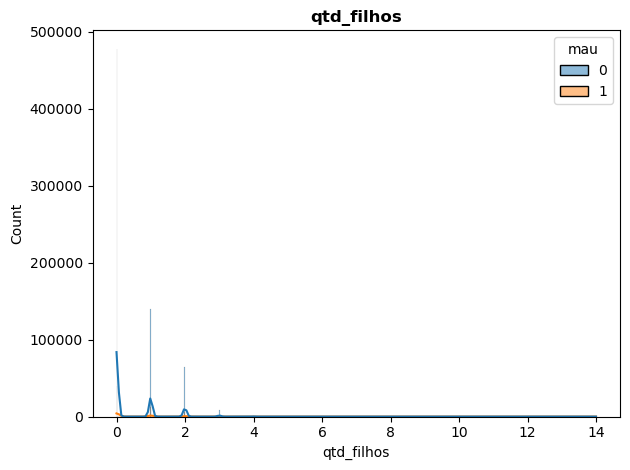

/Users/rayssaathayde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rayssaathayde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/rayssaathayde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/rayssaathayde/anaconda3/lib/python3.11/site-packag

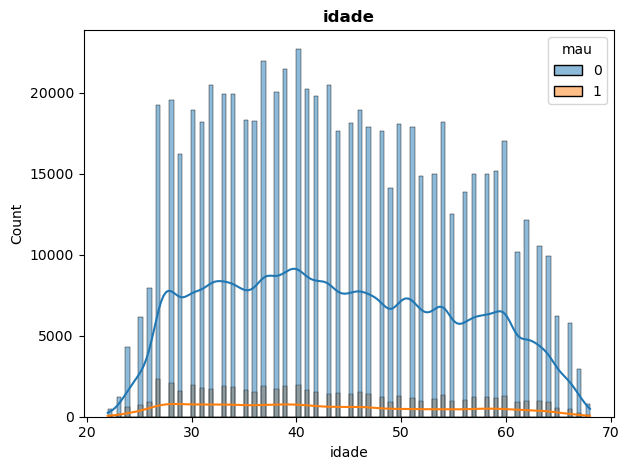

/Users/rayssaathayde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rayssaathayde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/rayssaathayde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


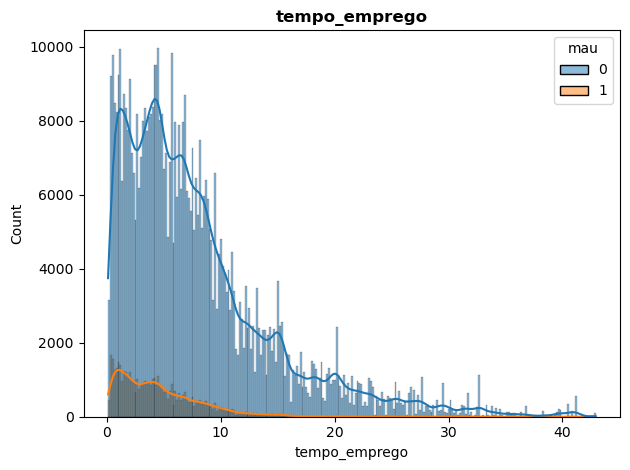

/Users/rayssaathayde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rayssaathayde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/rayssaathayde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


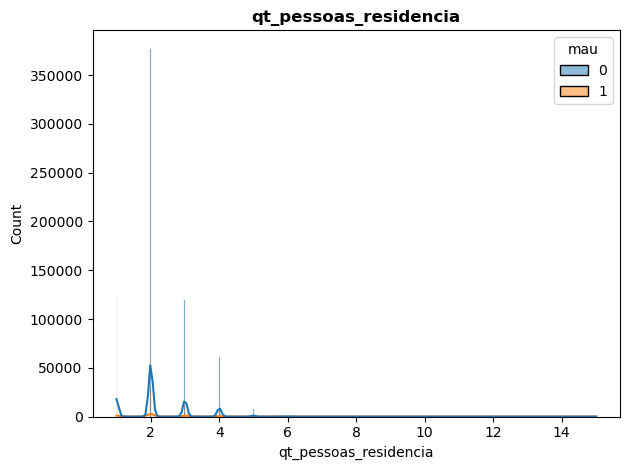

/Users/rayssaathayde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rayssaathayde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/rayssaathayde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


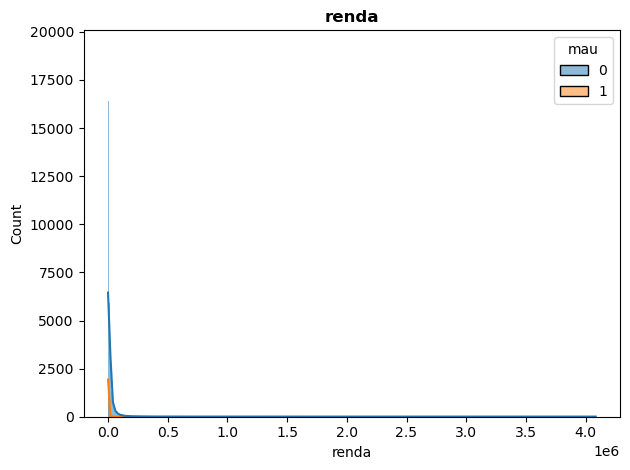

/Users/rayssaathayde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rayssaathayde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/rayssaathayde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/rayssaathayde/anaconda3/lib/python3.11/site-packag

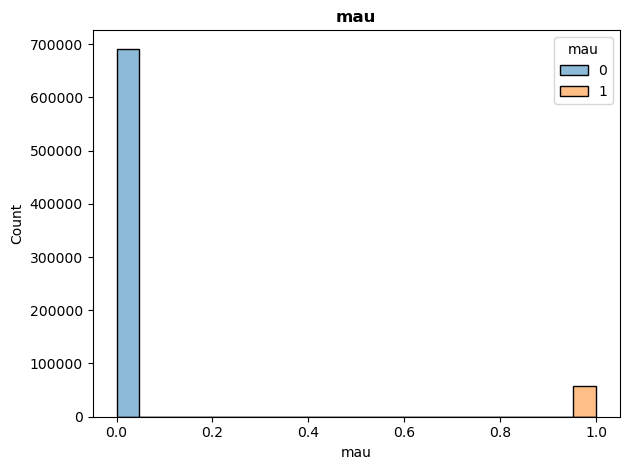

In [15]:
for col in cols_qtt:
    sns.histplot(data=df, x=col, kde=True, hue='mau')
    plt.title(col,weight="bold")
    plt.tight_layout()
    plt.show()
     

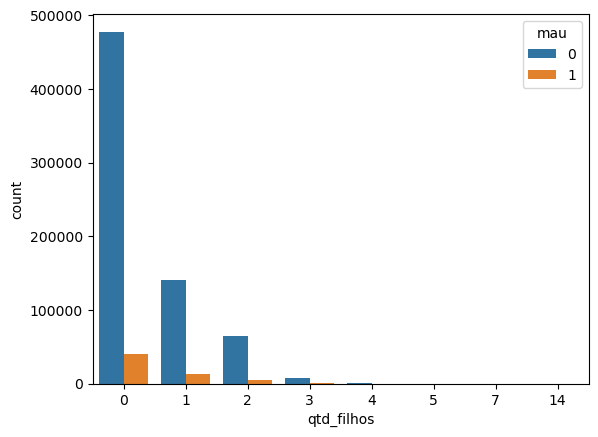

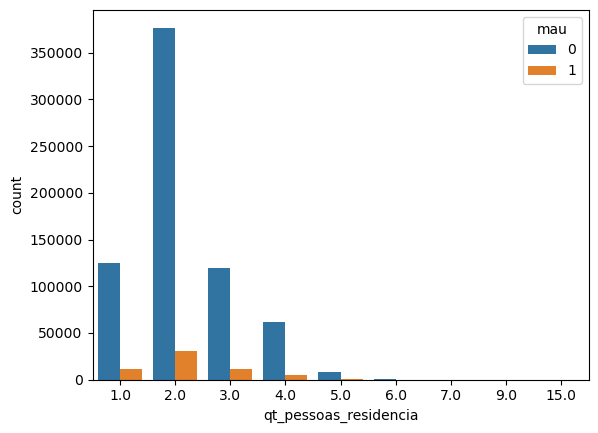

In [16]:
cols_countplot = ['qtd_filhos', 'qt_pessoas_residencia']

for col in cols_countplot:
    sns.countplot(df, x=col, hue='mau')
    plt.show()

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [17]:
def biva_point(col):
    plt.figure(figsize=(10, 6))

    sns.pointplot(x=col,
                  y='renda',
                  hue='mau',
                  data=df,
                  dodge=True,
                  errorbar=('ci', 95))
    plt.title(f'Distribuição de renda por {col}')
    plt.legend(loc='best')
    plt.xlabel(f'{col}')
    plt.ylabel('Renda')

    plt.show()

In [18]:
def biva_scatter(col):
    plt.figure(figsize=(10, 6))

    sns.scatterplot(x=col,
                    y='renda',
                    hue='mau',
                    data=df)
    plt.title(f'Distribuição de renda por {col}')
    plt.legend(loc='best')
    plt.xlabel(f'{col}')
    plt.ylabel('Renda')

    plt.show()

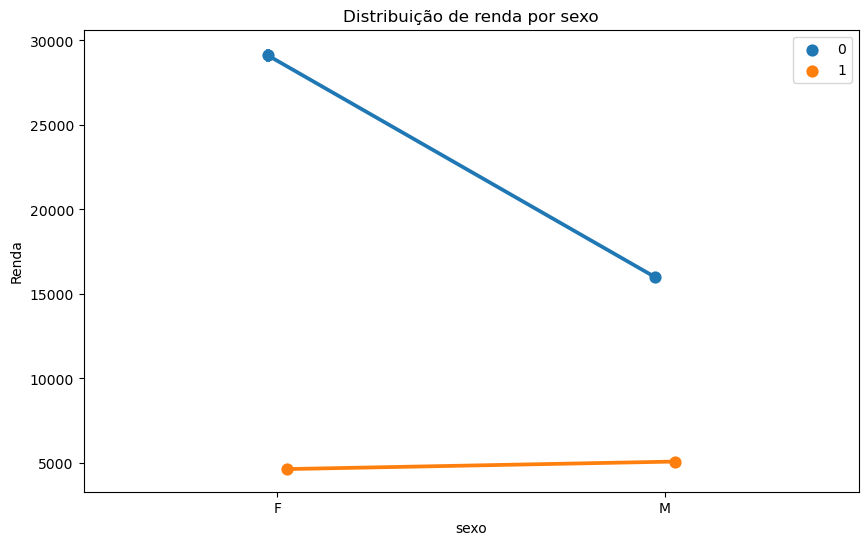

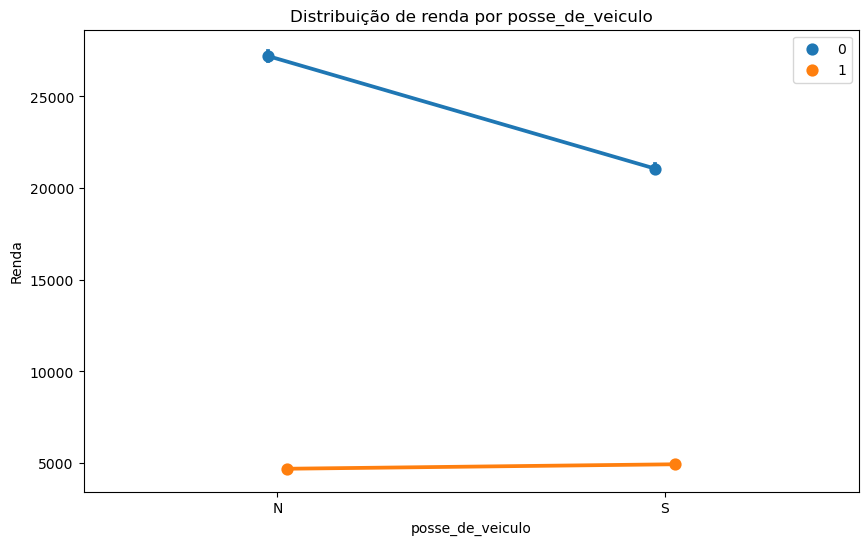

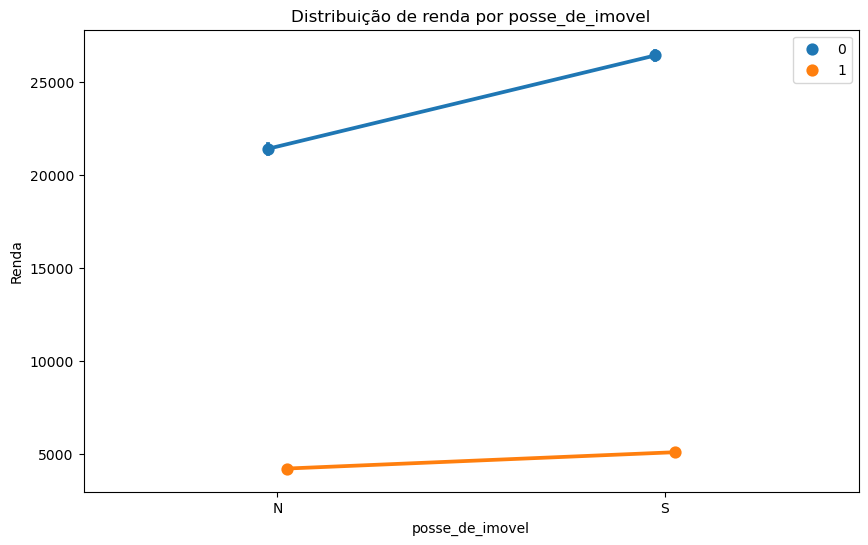

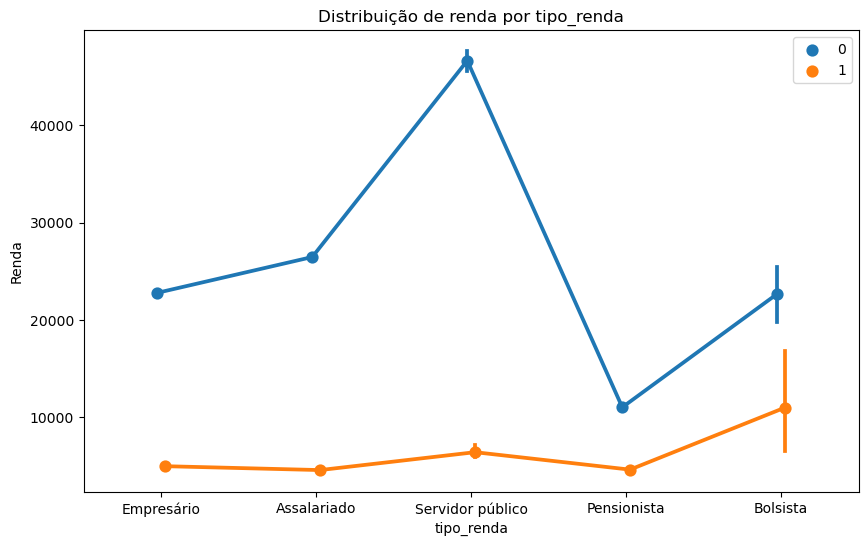

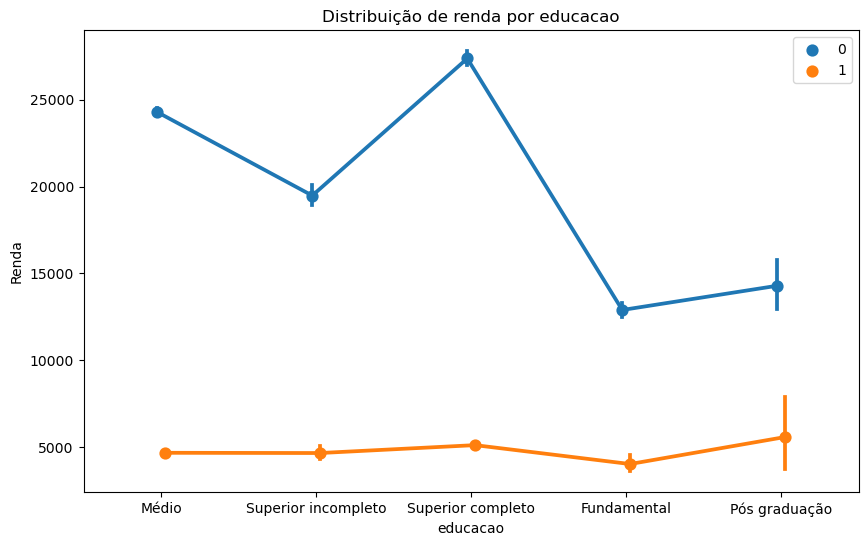

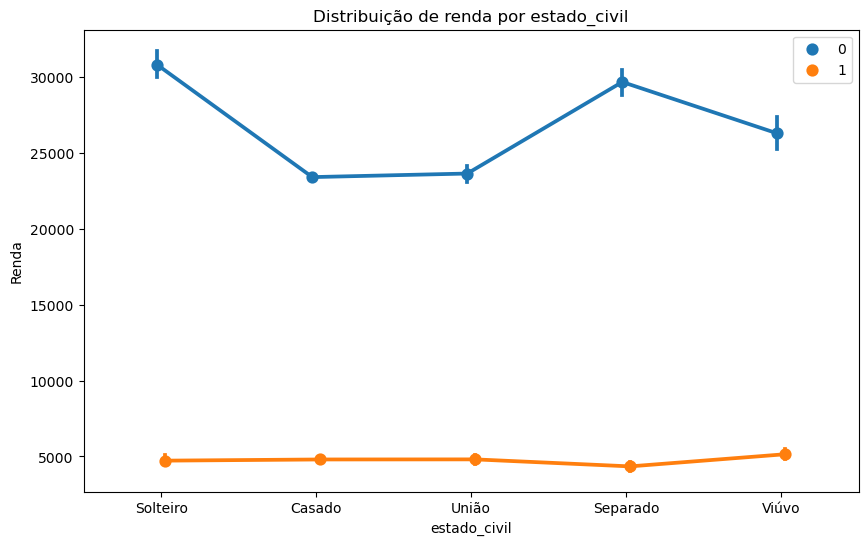

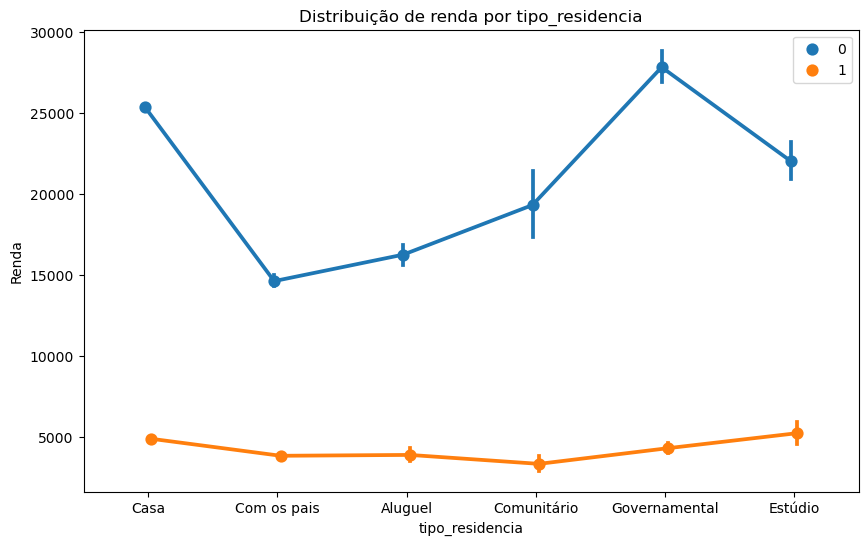

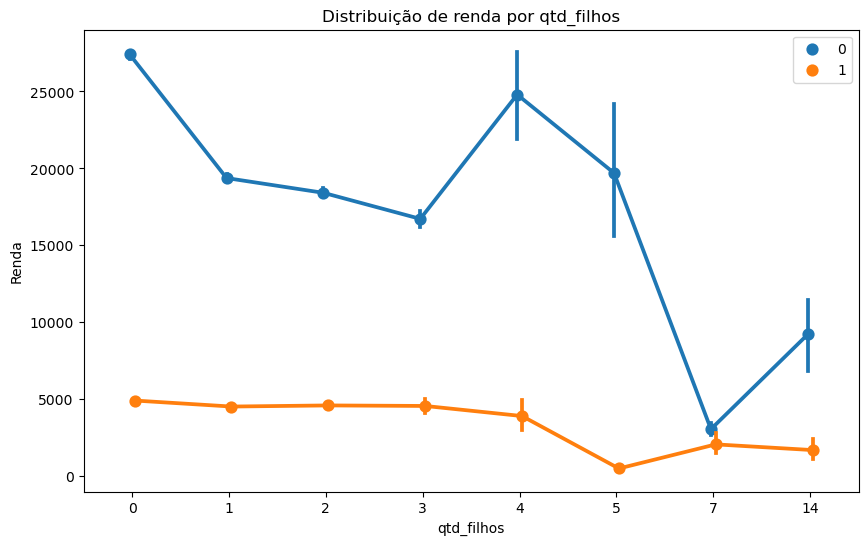

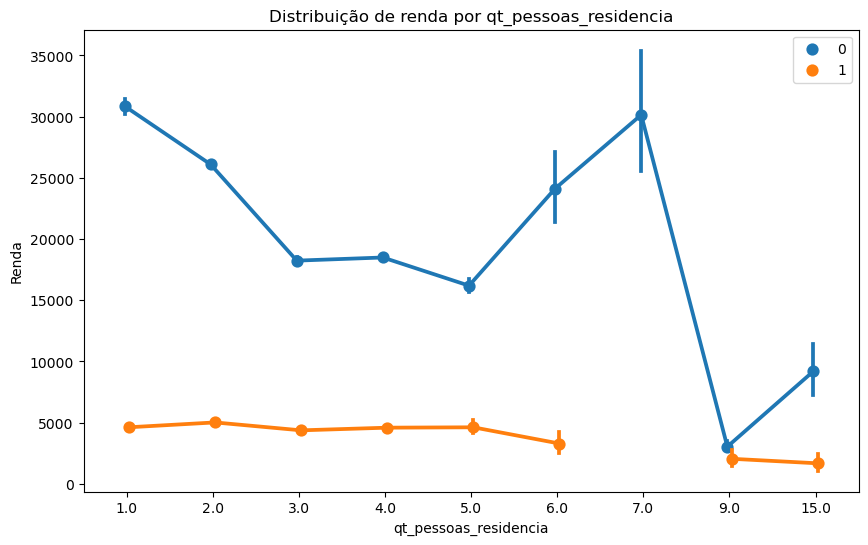

In [19]:
cols_point = ['sexo', 'posse_de_veiculo',
              'posse_de_imovel', 'tipo_renda',
              'educacao', 'estado_civil', 'tipo_residencia',
              'qtd_filhos', 'qt_pessoas_residencia']

for col in cols_point:
    biva_point(col)

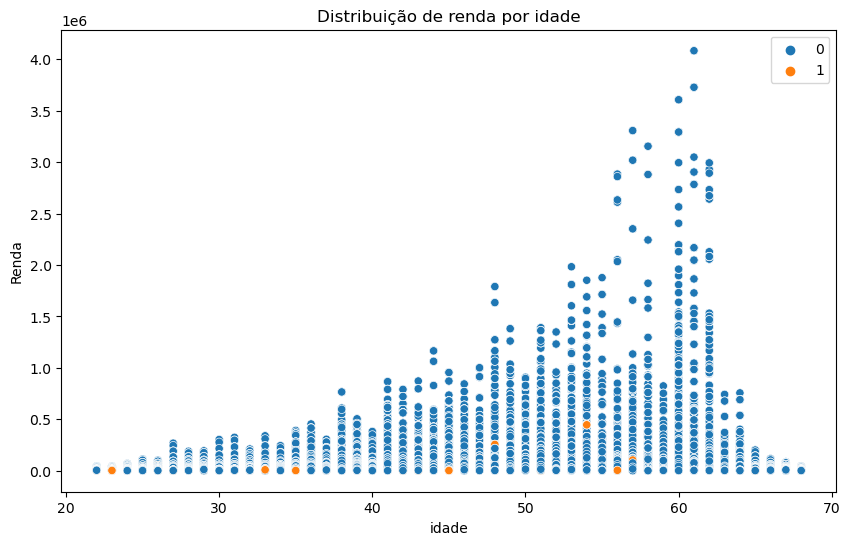

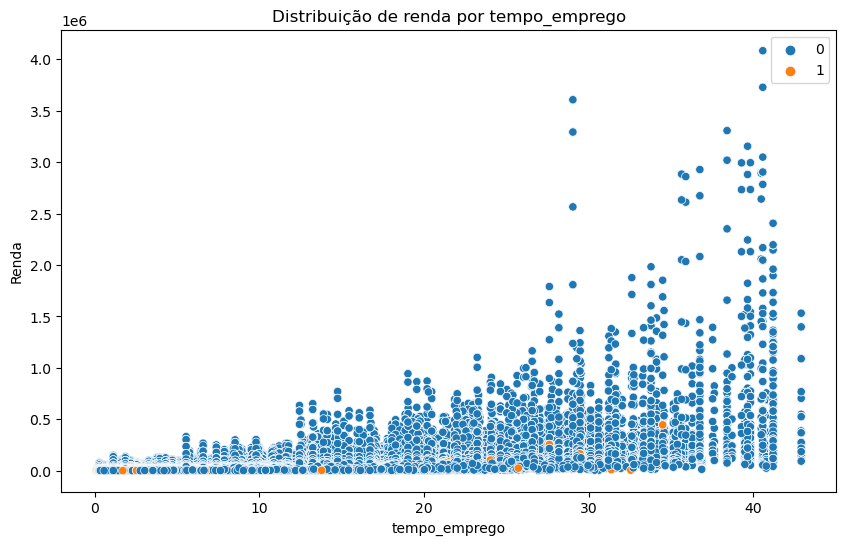

In [20]:
cols_scatter = ['idade', 'tempo_emprego']

for col in cols_scatter:
    biva_scatter(col)

/Users/rayssaathayde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rayssaathayde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/rayssaathayde/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/rayssaathayde/anaconda3/lib/python3.11/site-packag

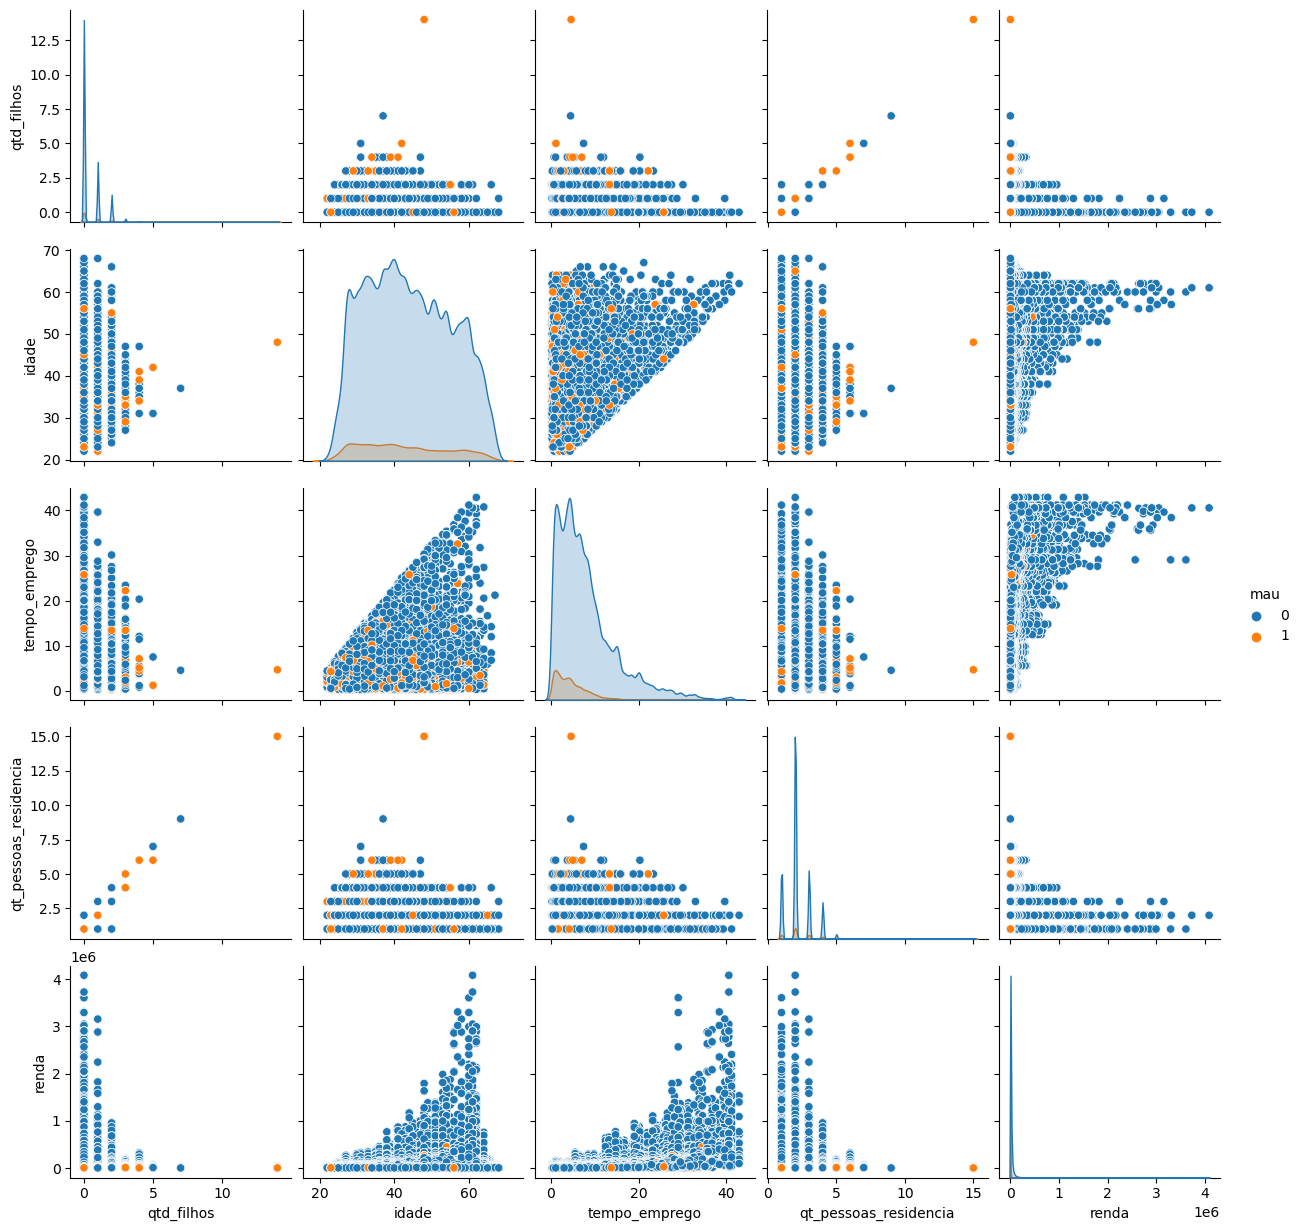

In [22]:
sns.pairplot(df, hue='mau')
plt.show()

<Axes: >

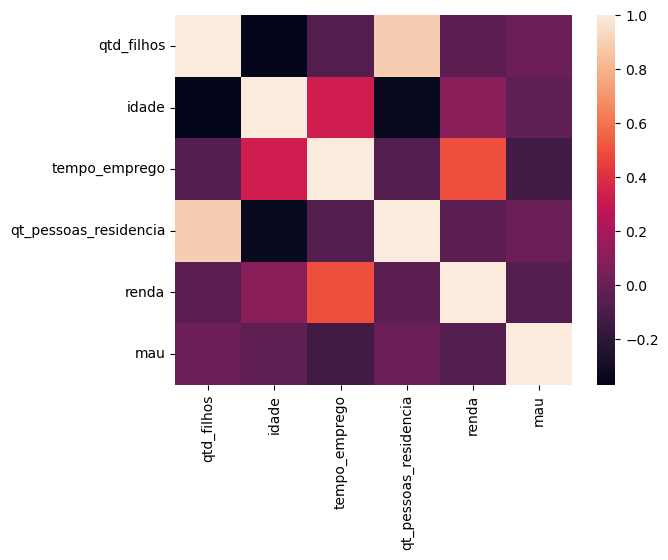

In [23]:
df_ = df[['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda', 'mau']]
df_corr = df_.corr()

sns.heatmap(df_corr)

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [24]:
#verificando valores faltantes
df_treino.isnull().sum()

data_ref                      0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            100875
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

In [25]:
#substituindo valores faltantes por média da variável
df['tempo_emprego'].fillna(df['tempo_emprego'].mean(), inplace=True)
df_treino['tempo_emprego'].fillna(df['tempo_emprego'].mean(), inplace=True)
df_teste['tempo_emprego'].fillna(df['tempo_emprego'].mean(), inplace=True)

/var/folders/wh/n65332rj7vx8p0vjpl2bjx8h0000gn/T/ipykernel_19530/1496336667.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['tempo_emprego'].fillna(df['tempo_emprego'].mean(), inplace=True)
/var/folders/wh/n65332rj7vx8p0vjpl2bjx8h0000gn/T/ipykernel_19530/1496336667.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are

In [26]:
df.isnull().sum()

data_ref                 0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64

In [27]:
df_treino.isnull().sum()

data_ref                 0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64

In [28]:
df_teste.isnull().sum()

data_ref                 0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64

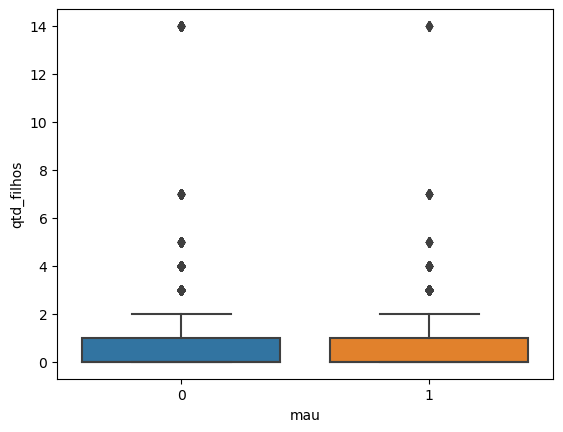

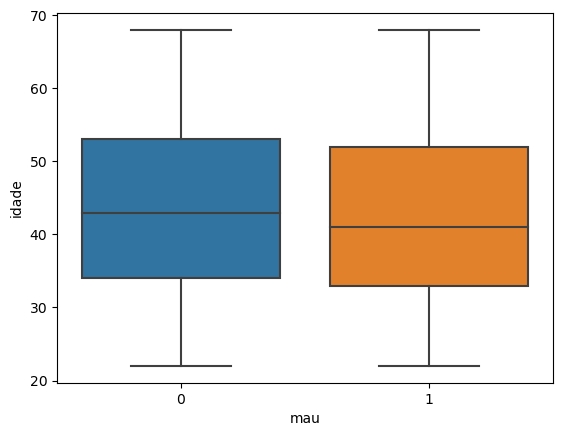

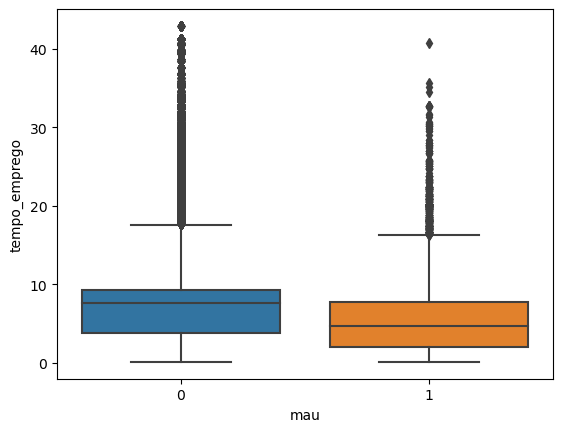

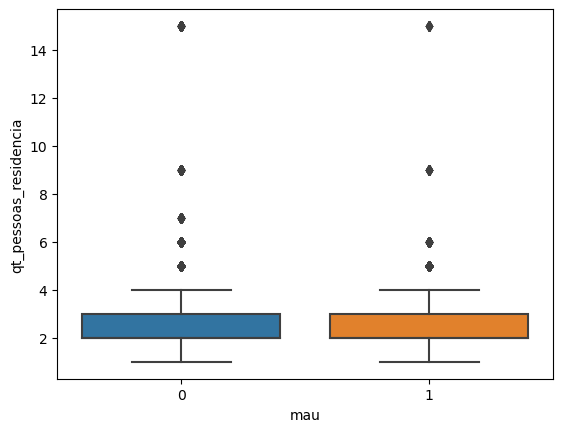

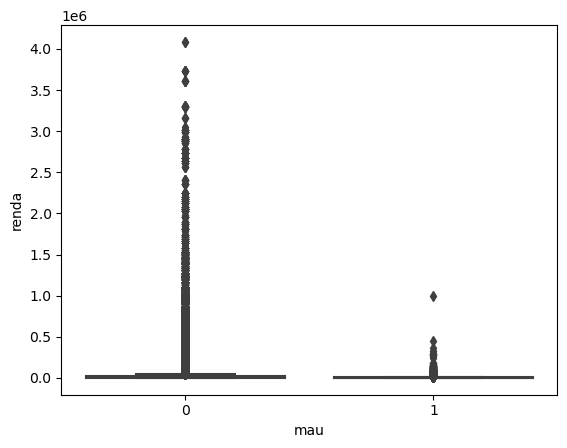

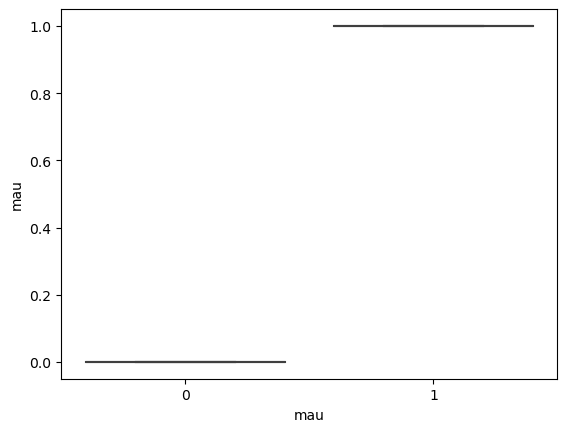

In [29]:
for col in cols_qtt:
    sns.boxplot(data=df_treino, x='mau', y=col)
    plt.show()

In [30]:
#retirando outliers de tempo de emprego
emprego = df_treino['tempo_emprego'].loc[df_treino['mau'] == 1].values
# Valores do quartil 25 e quartil 75
q25, q75 = np.percentile(emprego, 25), np.percentile(emprego, 75)
print('QUARTIL 25: {} | QUARTIL 75: {}'.format(q25, q75))
# Interquartile range
emprego_iqr = q75 - q25
print('IQR: ', emprego_iqr)

# Limiar
emprego_cut_off = emprego_iqr * 1.5
# Limite superior e inferior
emprego_lower, emprego_upper = q25 - emprego_cut_off, q75 + emprego_cut_off
print('LIMIAR: ', emprego_cut_off)
print('Tempo emprego LIMITE INFERIOR', emprego_lower)
print('Tempo emprego LIMITE SUPERIOR', emprego_upper)

# Ouliers (fora os limites estabelecidos anteriormente)
outliers = [x for x in emprego if x < emprego_lower or x > emprego_upper]
print('Tempo emprego QUANTIDADE DE OUTLIERS EM MAU PAGADORES:', len(outliers))

# Novo dataframe sem os outliers
df_treino = df_treino.drop(
    df_treino[(df_treino['tempo_emprego'] > emprego_upper) |
             (df_treino['tempo_emprego'] < emprego_lower)].index)

QUARTIL 25: 2.041095890410959 | QUARTIL 75: 7.748574052205171
IQR:  5.707478161794212
LIMIAR:  8.561217242691317
Tempo emprego LIMITE INFERIOR -6.520121352280357
Tempo emprego LIMITE SUPERIOR 16.30979129489649
Tempo emprego QUANTIDADE DE OUTLIERS EM MAU PAGADORES: 461


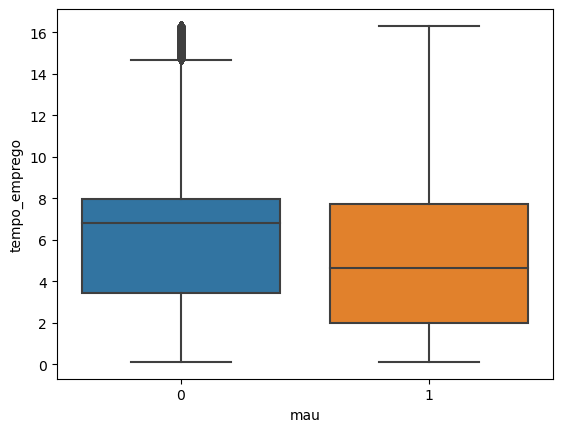

In [31]:
sns.boxplot(data=df_treino, x='mau', y='tempo_emprego')
plt.show()

In [33]:
#tabela de metadados

df = df.drop(columns=['data_ref'])
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['nmissing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados.loc['bom','papel'] = 'resposta'

metadados

,dtype,nmissing,valores_unicos,papel
sexo,object,0.0,2.0,covariavel
posse_de_veiculo,object,0.0,2.0,covariavel
posse_de_imovel,object,0.0,2.0,covariavel
qtd_filhos,int64,0.0,8.0,covariavel
tipo_renda,object,0.0,5.0,covariavel
educacao,object,0.0,5.0,covariavel
estado_civil,object,0.0,5.0,covariavel
tipo_residencia,object,0.0,6.0,covariavel
idade,int64,0.0,47.0,covariavel
tempo_emprego,float64,0.0,3005.0,covariavel


In [34]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [35]:
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df[var],5,duplicates='drop'), df.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)

    
metadados

,dtype,nmissing,valores_unicos,papel,IV
sexo,object,0.0,2.0,covariavel,0.002185
posse_de_veiculo,object,0.0,2.0,covariavel,0.000108
posse_de_imovel,object,0.0,2.0,covariavel,0.009693
qtd_filhos,int64,0.0,8.0,covariavel,0.000030
tipo_renda,object,0.0,5.0,covariavel,0.009360
educacao,object,0.0,5.0,covariavel,0.003547
estado_civil,object,0.0,5.0,covariavel,0.001126
tipo_residencia,object,0.0,6.0,covariavel,0.003045
idade,int64,0.0,47.0,covariavel,0.017968
tempo_emprego,float64,0.0,3005.0,covariavel,0.278819


In [36]:
metadados.loc[metadados['IV'] <= 0.02, 'IV_cat'] = 'inútil' 
metadados.loc[(metadados['IV'] > 0.02) & (metadados['IV'] <= 0.1), 'IV_cat'] = 'fraco'
metadados.loc[(metadados['IV'] > 0.1) & (metadados['IV'] <= 0.3), 'IV_cat'] = 'médio'
metadados.loc[(metadados['IV'] > 0.3) & (metadados['IV'] <= 0.5), 'IV_cat'] = 'forte'
metadados.loc[metadados['IV'] > 0.5, 'IV_cat'] = 'alto' 

metadados

,dtype,nmissing,valores_unicos,papel,IV,IV_cat
sexo,object,0.0,2.0,covariavel,0.002185,inútil
posse_de_veiculo,object,0.0,2.0,covariavel,0.000108,inútil
posse_de_imovel,object,0.0,2.0,covariavel,0.009693,inútil
qtd_filhos,int64,0.0,8.0,covariavel,0.000030,inútil
tipo_renda,object,0.0,5.0,covariavel,0.009360,inútil
educacao,object,0.0,5.0,covariavel,0.003547,inútil
estado_civil,object,0.0,5.0,covariavel,0.001126,inútil
tipo_residencia,object,0.0,6.0,covariavel,0.003045,inútil
idade,int64,0.0,47.0,covariavel,0.017968,inútil
tempo_emprego,float64,0.0,3005.0,covariavel,0.278819,médio


In [37]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    return biv

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,6332,480,0.070464,Fundamental,6812,0.003101,0.076542,0.064385,-2.579585,-2.490279,-2.676319,0.071015,0.160322,-0.025718
Médio,342759,25160,0.068385,Médio,367919,0.000416,0.069200,0.067569,-2.611772,-2.599040,-2.624645,0.038828,0.051560,0.025955
Pós graduação,573,41,0.066775,Pós graduação,614,0.010074,0.086560,0.046991,-2.637314,-2.356384,-3.009672,0.013287,0.294216,-0.359072
Superior completo,142094,8989,0.059497,Superior completo,151083,0.000609,0.060690,0.058304,-2.760487,-2.739368,-2.782007,-0.109887,-0.088768,-0.131406
Superior incompleto,20671,1512,0.068160,Superior incompleto,22183,0.001692,0.071477,0.064844,-2.615298,-2.564220,-2.668734,0.035302,0.086380,-0.018134


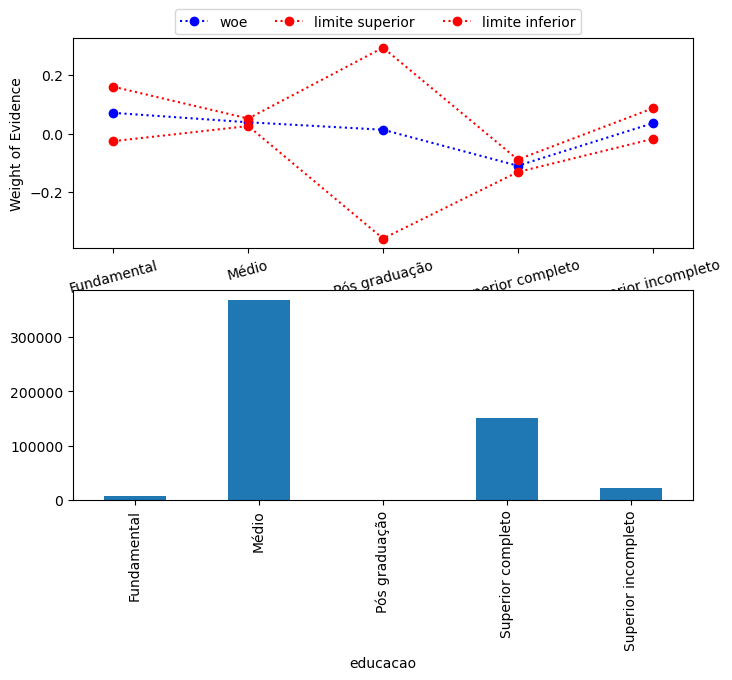

In [38]:
biv_discreta('educacao', df_treino)

/var/folders/wh/n65332rj7vx8p0vjpl2bjx8h0000gn/T/ipykernel_19530/2781972383.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_treino1.educacao.replace(


,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Ens. Superior,163338,10542,0.060628,Ens. Superior,173880,0.000572,0.061750,0.059506,-2.740454,-2.720927,-2.760323,-0.089854,-0.070327,-0.109722
Medio ou inferior,349091,25640,0.068422,Medio ou inferior,374731,0.000412,0.069231,0.067614,-2.611179,-2.598566,-2.623931,0.039421,0.052034,0.026670


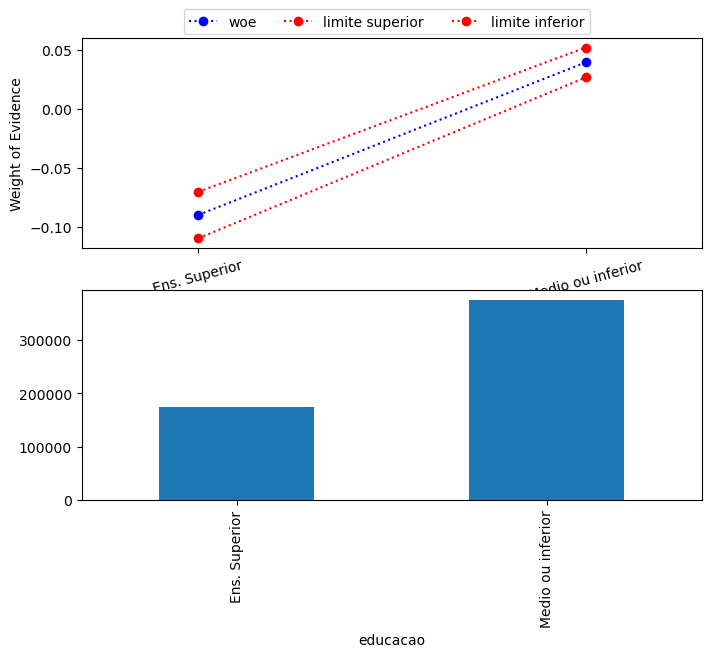

In [39]:
df_treino1 = df_treino.copy()
df_treino1.educacao.replace(
    {
        'Fundamental': 'Medio ou inferior',
        'Médio': 'Medio ou inferior',
        'Superior completo': 'Ens. Superior',
        'Pós graduação': 'Ens. Superior',
        'Superior incompleto': 'Ens. Superior'
    },
    inplace=True)

biv_discreta('educacao', df_treino1)

,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel,7422,593,0.073986,Aluguel,8015,0.002924,0.079717,0.068255,-2.527009,-2.446192,-2.613807,0.123591,0.204409,0.036793
Casa,460658,32028,0.065007,Casa,492686,0.000351,0.065695,0.064319,-2.666045,-2.654775,-2.677428,-0.015445,-0.004174,-0.026827
Com os pais,23426,1979,0.077898,Com os pais,25405,0.001681,0.081194,0.074602,-2.471255,-2.426236,-2.518053,0.179346,0.224365,0.132547
Comunitário,2247,184,0.075689,Comunitário,2431,0.005365,0.086209,0.065169,-2.502416,-2.360833,-2.663374,0.148185,0.289768,-0.012774
Estúdio,3772,222,0.055583,Estúdio,3994,0.003625,0.062691,0.048476,-2.832683,-2.704794,-2.977003,-0.182083,-0.054193,-0.326403
Governamental,14904,1176,0.073134,Governamental,16080,0.002053,0.077159,0.069110,-2.539511,-2.481592,-2.600444,0.111090,0.169009,0.050157


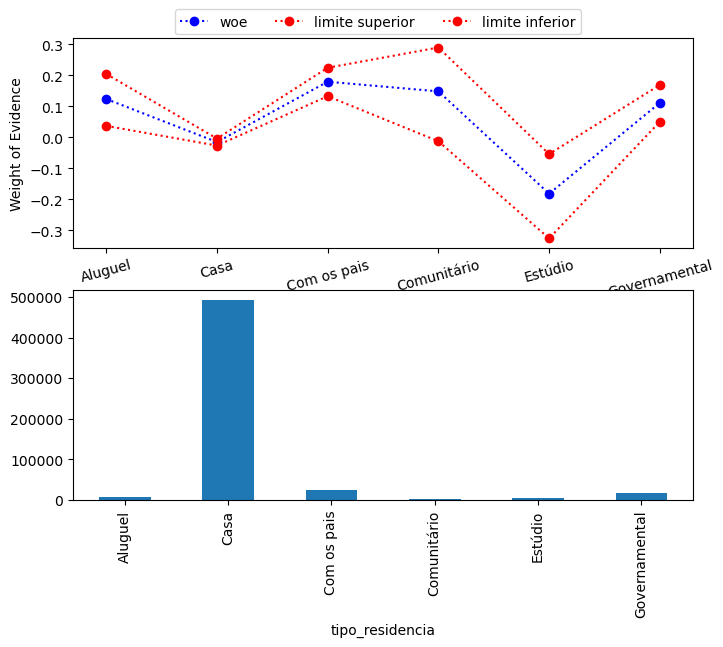

In [40]:
biv_discreta('tipo_residencia', df_treino)

/var/folders/wh/n65332rj7vx8p0vjpl2bjx8h0000gn/T/ipykernel_19530/635942314.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_treino1.tipo_residencia.replace(


,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel/Comun./Auxilio,47999,3932,0.075716,Aluguel/Comun./Auxilio,51931,0.001161,0.077991,0.073441,-2.502032,-2.469959,-2.535002,0.148568,0.180641,0.115598
Casa,464430,32250,0.064931,Casa,496680,0.000350,0.065616,0.064246,-2.667293,-2.656061,-2.678635,-0.016692,-0.005461,-0.028035


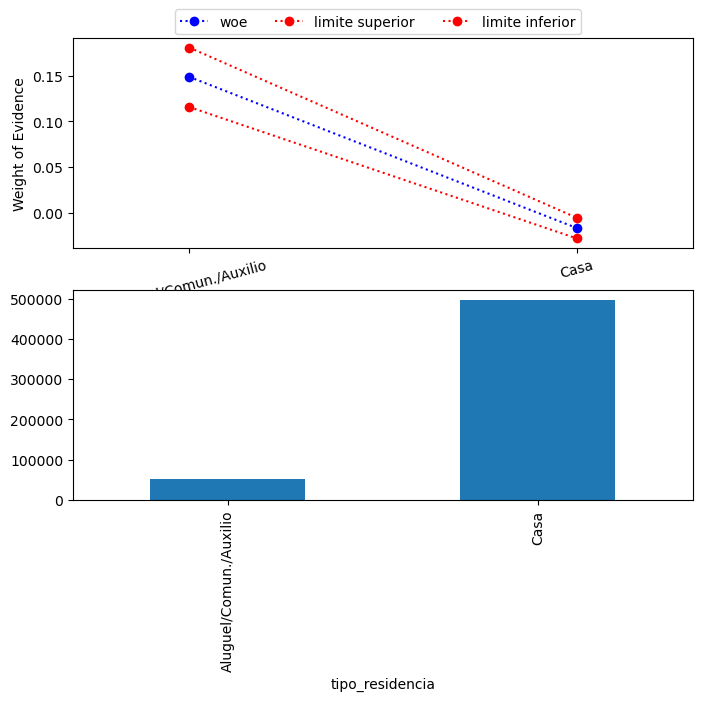

In [41]:
df_treino1.tipo_residencia.replace(
    {
        'Aluguel': 'Aluguel/Comun./Auxilio',
        'Com os pais': 'Aluguel/Comun./Auxilio',
        'Comunitário': 'Aluguel/Comun./Auxilio',
        'Estúdio': 'Casa',
        'Governamental' : 'Aluguel/Comun./Auxilio'
    },
    inplace=True)
biv_discreta('tipo_residencia', df_treino1)

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,256732,19272,0.069825,Assalariado,276004,0.000485,0.070776,0.068874,-2.589379,-2.574832,-2.604111,0.061221,0.075768,0.046489
Bolsista,279,12,0.041237,Bolsista,291,0.011656,0.064178,0.018296,-3.146305,-2.679758,-3.982616,-0.495705,-0.029158,-1.332016
Empresário,120898,8139,0.063075,Empresário,129037,0.000677,0.064401,0.061749,-2.698280,-2.676052,-2.720948,-0.047679,-0.025452,-0.070347
Pensionista,94627,6500,0.064276,Pensionista,101127,0.000771,0.065787,0.062764,-2.678141,-2.653280,-2.703552,-0.027540,-0.002679,-0.052952
Servidor público,39893,2259,0.053592,Servidor público,42152,0.001097,0.055742,0.051442,-2.871279,-2.829670,-2.914493,-0.220678,-0.179070,-0.263893


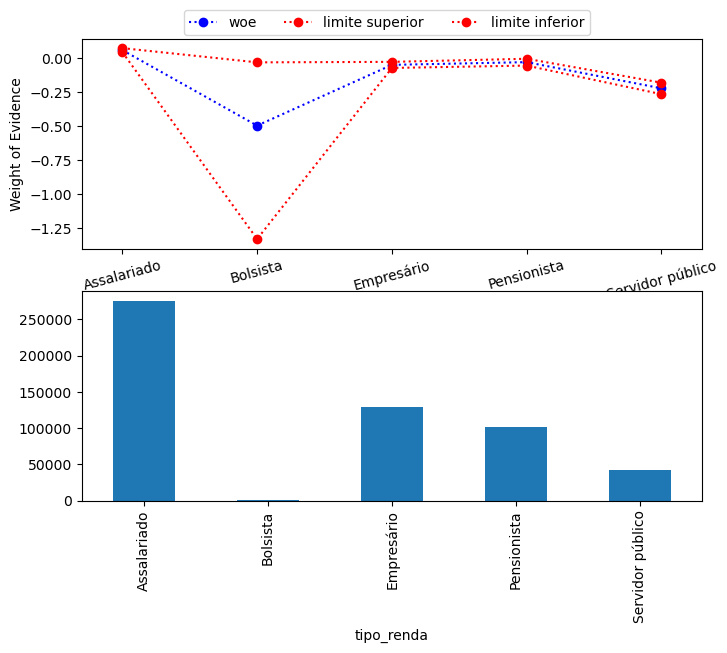

In [42]:
biv_discreta('tipo_renda', df_treino)

/var/folders/wh/n65332rj7vx8p0vjpl2bjx8h0000gn/T/ipykernel_19530/1477039592.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_treino1.tipo_renda.replace(


,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Empresário,120898,8139,0.063075,Empresário,129037,0.000677,0.064401,0.061749,-2.69828,-2.676052,-2.720948,-0.047679,-0.025452,-0.070347
Renda fixa,351359,25772,0.068337,Renda fixa,377131,0.000411,0.069142,0.067532,-2.61252,-2.599940,-2.625238,0.038081,0.050661,0.025362
Serv.Publico./Estudante,40172,2271,0.053507,Serv.Publico./Estudante,42443,0.001092,0.055648,0.051366,-2.87295,-2.831451,-2.916046,-0.222350,-0.180851,-0.265446


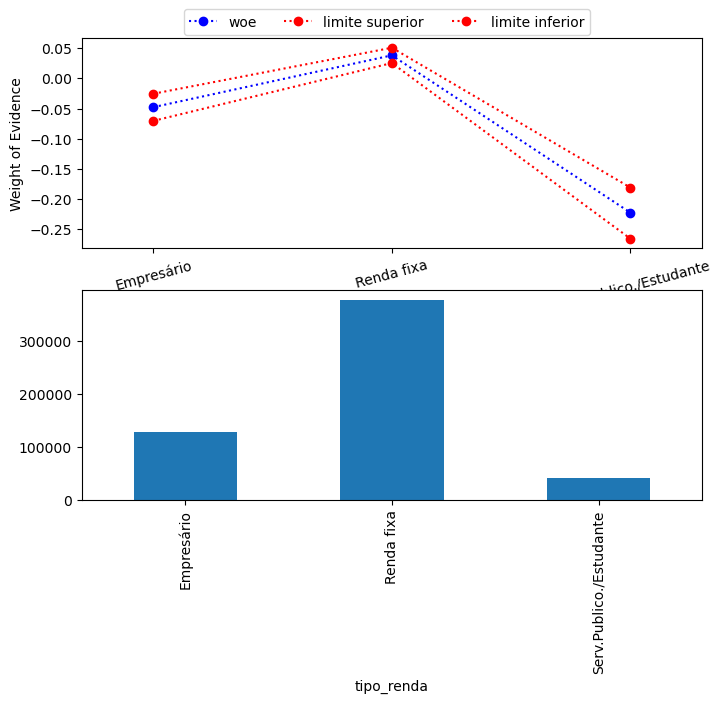

In [43]:
df_treino1.tipo_renda.replace(
    {
        'Bolsista': 'Serv.Publico./Estudante',
        'Servidor público': 'Serv.Publico./Estudante',
        'Assalariado': 'Renda fixa',
        'Pensionista': 'Renda fixa'
    },
    inplace=True)
biv_discreta('tipo_renda', df_treino1)

In [44]:
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

/var/folders/wh/n65332rj7vx8p0vjpl2bjx8h0000gn/T/ipykernel_19530/707398857.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


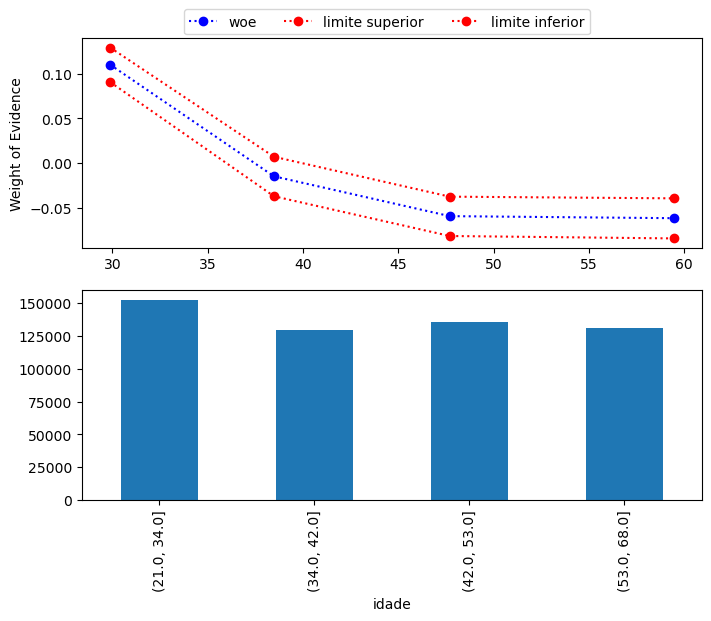

In [45]:
biv_continua('idade', 4, df_treino)

/var/folders/wh/n65332rj7vx8p0vjpl2bjx8h0000gn/T/ipykernel_19530/707398857.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


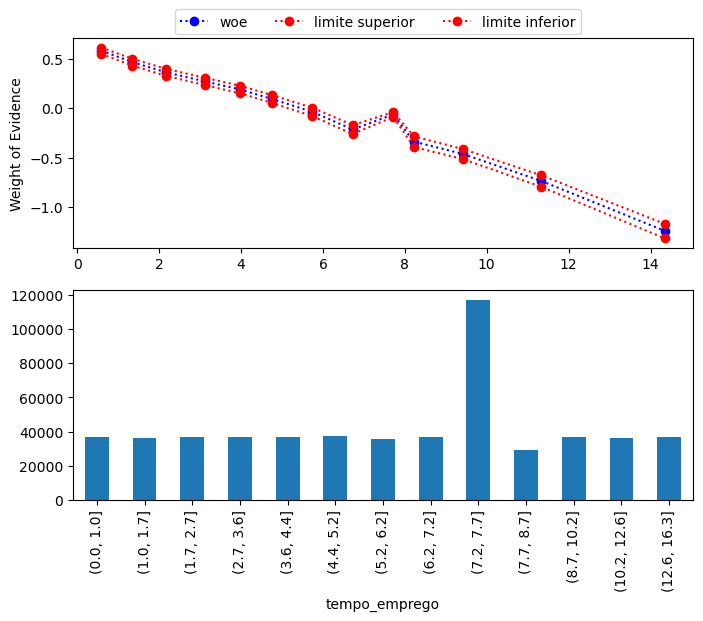

In [46]:
biv_continua('tempo_emprego', 15, df_treino)

/var/folders/wh/n65332rj7vx8p0vjpl2bjx8h0000gn/T/ipykernel_19530/707398857.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


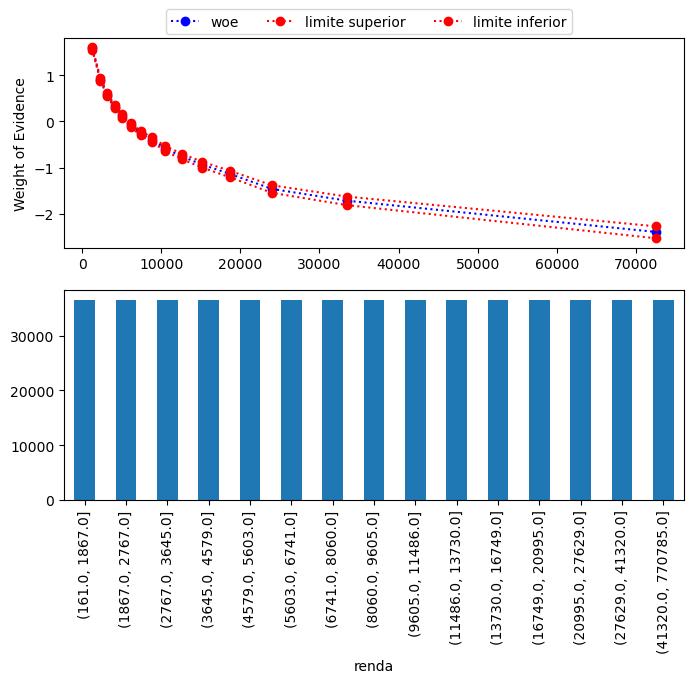

In [47]:
biv_continua('renda', 15, df_treino)

In [48]:
#mudanças nas variaveis na base de teste

df_teste1 = df_teste.copy()
df_teste1.tipo_renda.replace(
    {
        'Bolsista': 'Serv.Publico./Estudante',
        'Servidor público': 'Serv.Publico./Estudante',
        'Assalariado': 'Renda fixa',
        'Pensionista': 'Renda fixa'
    },
    inplace=True)

df_teste1.educacao.replace(
    {
        'Fundamental': 'Medio ou inferior',
        'Médio': 'Medio ou inferior',
        'Superior completo': 'Ens. Superior',
        'Pós graduação': 'Ens. Superior',
        'Superior incompleto': 'Ens. Superior'
    },
    inplace=True)

df_teste1.tipo_residencia.replace(
    {
        'Aluguel': 'Aluguel/comunitario/Auxilio',
        'Com os pais': 'Aluguel/comunitario/Auxilio',
        'Comunitário': 'Aluguel/comunitario/Auxilio',
        'Estúdio': 'Casa',
        'Governamental' : 'Aluguel/comunitario/Auxilio'
    },
    inplace=True)

/var/folders/wh/n65332rj7vx8p0vjpl2bjx8h0000gn/T/ipykernel_19530/3044461555.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_teste1.tipo_renda.replace(
/var/folders/wh/n65332rj7vx8p0vjpl2bjx8h0000gn/T/ipykernel_19530/3044461555.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

In [49]:
#Proponha uma equação preditiva para 'mau'

formula = '''
    mau ~ renda + tempo_emprego 
          + idade + posse_de_imovel 
          + tipo_renda + educacao 
          + tipo_residencia + sexo 
          + qt_pessoas_residencia 
          + estado_civil + posse_de_veiculo 
          + qtd_filhos
'''

rl = smf.glm(formula, data=df_treino1, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               548611
Model:                            GLM   Df Residuals:                   548594
Model Family:                Binomial   Df Model:                           16
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2146e+05
Date:                Fri, 10 May 2024   Deviance:                   2.4293e+05
Time:                        09:15:39   Pearson chi2:                 1.50e+13
No. Iterations:                     8   Pseudo R-squ. (CS):            0.04235
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -1.2336      0.182     -6.793      0.000      -1.590      -0.878
posse_de_imovel[T.S]                     -0.0740      0.012     -6.220      0.000      -0.097      -0.051
tipo_renda[T.Renda fixa]                  0.0413      0.014      2.974      0.003       0.014       0.069
tipo_renda[T.Serv.Publico./Estudante]     0.0217      0.025      0.863      0.388      -0.028       0.071
educacao[T.Medio ou inferior]             0.0511      0.013      4.021      0.000       0.026       0.076
tipo_residencia[T.Casa]                  -0.0168      0.018     -0.909      0.364      -0.053       0.019
sexo[T.M]                                -0.1066      0.013     -8.055      0.000      -0.133      -0.081
estado_civil[T.Separado]                 -0.0876      0.093     -0.947      0.344      -0.269       0.094
estado_civil[T.Solteiro]                 -0.1188      0.091     -1.312      0.190      -0.296       0.059
estado_civil[T.União]                     0.0393      0.021      1.913      0.056      -0.001       0.079
estado_civil[T.Viúvo]                    -0.1525      0.094     -1.620      0.105      -0.337       0.032
posse_de_veiculo[T.S]                     0.0328      0.012      2.632      0.008       0.008       0.057
renda                                    -0.0001   1.21e-06    -98.627      0.000      -0.000      -0.000
tempo_emprego                            -0.0265      0.002    -13.804      0.000      -0.030      -0.023
idade                                    -0.0001      0.001     -0.172      0.863      -0.001       0.001
qt_pessoas_residencia                    -0.1193      0.089     -1.333      0.183      -0.295       0.056
qtd_filhos                                0.1217      0.090      1.358      0.174      -0.054       0.297
=========================================================================================================
"""

In [50]:
#Retirando as variaveis com p-value > 0.05

formula = '''
    mau ~ renda + tempo_emprego 
          + posse_de_imovel 
          + educacao 
          + sexo 
          + posse_de_veiculo 
'''

rl1 = smf.glm(formula, data=df_treino1, family=sm.families.Binomial()).fit()

rl1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               548611
Model:                            GLM   Df Residuals:                   548604
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2147e+05
Date:                Fri, 10 May 2024   Deviance:                   2.4295e+05
Time:                        09:15:52   Pearson chi2:                 1.66e+13
No. Iterations:                     8   Pseudo R-squ. (CS):            0.04232
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -1.4561      0.017    -87.609      0.000      -1.489      -1.424
posse_de_imovel[T.S]             -0.0775      0.012     -6.709      0.000      -0.100      -0.055
educacao[T.Medio ou inferior]     0.0550      0.012      4.462      0.000       0.031       0.079
sexo[T.M]                        -0.1040      0.013     -7.987      0.000      -0.129      -0.078
posse_de_veiculo[T.S]             0.0311      0.012      2.529      0.011       0.007       0.055
renda                            -0.0001   1.21e-06    -98.956      0.000      -0.000      -0.000
tempo_emprego                    -0.0263      0.002    -14.508      0.000      -0.030      -0.023
=================================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [52]:
#primeiro modelo
df_treino1['score'] = rl.predict(df_treino1)

# Acurácia
acc = metrics.accuracy_score(df_treino1.mau, df_treino1.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_treino1.mau, df_treino1.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_treino1.loc[df_treino1.mau == 1, 'score'], df_treino1.loc[df_treino1.mau != 1, 'score']).statistic

print('Acurácia na base de treino: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia na base de treino: 57.2% 
AUC: 75.2% 
GINI: 50.4%
KS: 37.3%


In [53]:
#segundo modelo
df_treino1['score1'] = rl1.predict(df_treino1)

# Acurácia
acc = metrics.accuracy_score(df_treino1.mau, df_treino1.score1>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_treino1.mau, df_treino1.score1)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_treino1.loc[df_treino1.mau == 1, 'score1'], df_treino1.loc[df_treino1.mau != 1, 'score1']).statistic

print('Acurácia na base de treino: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia na base de treino: 57.2% 
AUC: 75.2% 
GINI: 50.4%
KS: 37.4%


In [56]:
df_teste1['score'] = rl1.predict(df_teste1)

# Acurácia
acc = metrics.accuracy_score(df_teste1.mau, df_teste1.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_teste1.mau, df_teste1.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_teste1.loc[df_teste1.mau == 1, 'score'], df_teste1.loc[df_teste1.mau != 1, 'score']).statistic

print('Acurácia na base de treino: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia na base de treino: 33.2% 
AUC: 72.7% 
GINI: 45.5%
KS: 33.3%
